In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import ticker

from protein_search_evals.datasets.radicalsam import RadicalSamDataset
from protein_search_evals.evaluate import EvaluationMetadata

/Users/abrace/projects/kbase/src/protein_search_evals/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Sequence length distribution

In [26]:
def plot_histogram(
    data: list[float] | list[int],
    xlabel: str,
    ylabel: str,
    title: str = '',
    bins: int | None = None,
    save_path: str | None = None,
) -> None:
    """Plot a histogram with automatically computed number of bins.

    Parameters
    ----------
    data : list[float] | list[int]
        Data to plot in the histogram.
    xlabel : str
        Label for the x-axis.
    ylabel : str
        Label for the y-axis.
    title : str, optional
        Title of the plot, by default "" (no title).
    bins : int | None, optional
        The number of bins to use.
    save_path : str | None, optional
        If provided, saves the figure to the given path, by default None.

    Returns
    -------
    None
    """
    # High-quality publication settings
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update(
        {
            'font.family': 'serif',
            'font.size': 14,
            'axes.titlesize': 16,
            'axes.labelsize': 14,
            'xtick.labelsize': 12,
            'ytick.labelsize': 12,
            'figure.dpi': 300,
        },
    )

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the histogram
    ax.hist(data, bins=bins, color='steelblue', edgecolor='black', alpha=0.7)

    # Customize the plot
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title:
        ax.set_title(title)
    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

    # Optimize layout
    plt.tight_layout()

    # Save if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

In [27]:
data_dir = '../../data/radicalsam'
sequences = RadicalSamDataset(data_dir, partition='all').load_sequences()

Loading Radical SAM sequences from ../../data/radicalsam/all/sequences.fasta


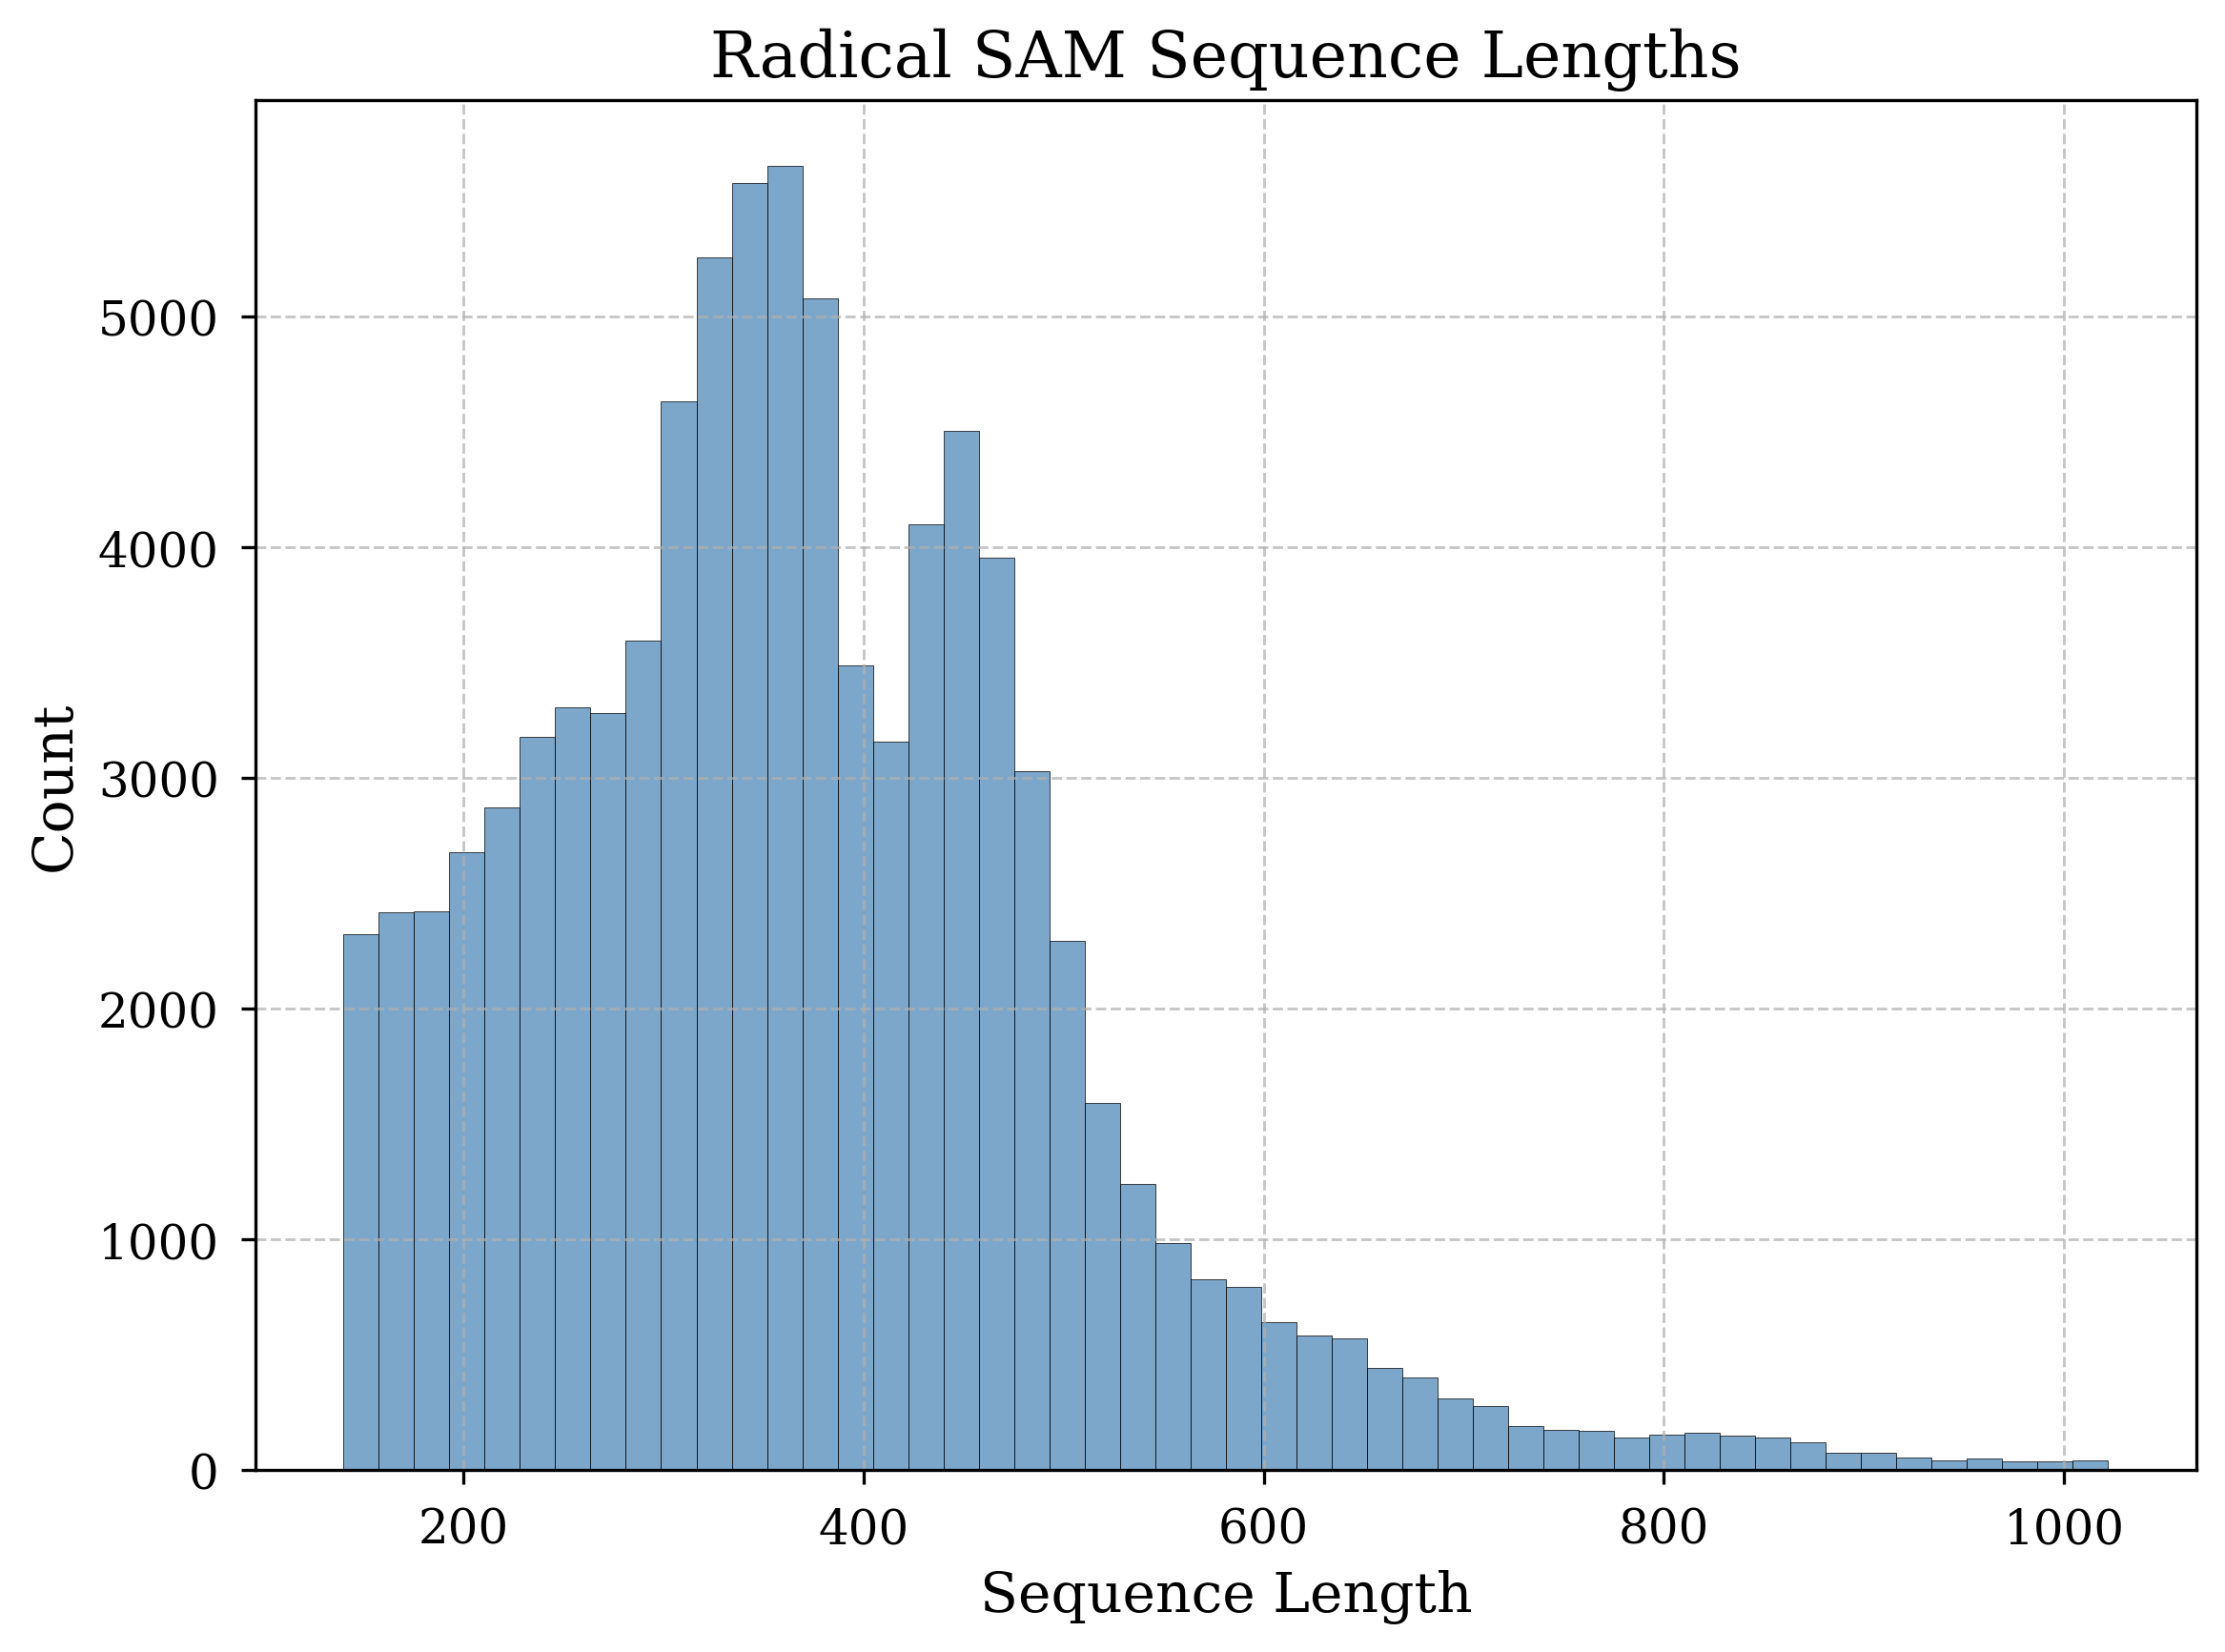

In [28]:
# Plot the sequence lengths
lengths = [len(x.sequence) for x in sequences]

plot_histogram(
    data=lengths,
    xlabel='Sequence Length',
    ylabel='Count',
    title='Radical SAM Sequence Lengths',
    bins=50,
)

# Accuracy evaluation

In [4]:
def get_metadata(
    model_names: list[str],
    precision: str,
    partition: str,
) -> list[EvaluationMetadata]:
    """Load the evaluation metadata for a list of model names.

    Parameters
    ----------
    model_names : list[str]
        List of model names.
    precision : str
        Precision of the model.
    partition : str
        Partition of the dataset.

    Returns
    -------
    list[EvaluationMetadata]
        List of evaluation metadata objects.
    """
    # The root path for the evaluation metadata of the given partition
    path = Path('evaluations/reports') / partition

    # Construct the paths for the evaluation metadata
    eval_paths = [
        path / f'report_{model_name}_{precision}_{partition}_metadata.json'
        for model_name in model_names
    ]

    # Load the evaluation metadata
    return [EvaluationMetadata.from_json(x) for x in eval_paths]


def get_accuracies(
    metadata: list[EvaluationMetadata],
    metric: str,
) -> list[float]:
    """Get the accuracies from a list of evaluation metadata objects.

    Parameters
    ----------
    metadata : list[EvaluationMetadata]
        List of evaluation metadata objects.
    metric : str
        Metric to extract the accuracies from.

    Returns
    -------
    list[float]
        List of accuracies.
    """
    if metric == 'sequence_level_mean_accuracy':
        return [x.sequence_level_mean_accuracy for x in metadata]
    elif metric == 'cluster_level_mean_accuracy':
        return [x.cluster_level_mean_accuracy for x in metadata]
    elif metric == 'cluster_level_median_accuracy':
        return [x.cluster_level_median_accuracy for x in metadata]
    else:
        raise ValueError(f'Invalid metric: {metric}')


# Model names for the ESM-2 models
esm2_model_names = [
    'esm2_t6_8M_UR50D',
    'esm2_t12_35M_UR50D',
    'esm2_t30_150M_UR50D',
    'esm2_t33_650M_UR50D',
    'esm2_t36_3B_UR50D',
]

# Model names for the ESM-C models
esmc_model_names = [
    'esmc_300m',
    'esmc_600m',
]

# Model name for ProtTrans
prottrans_model_names = [
    'prot_t5_xl_half_uniref50-enc',
]

In [5]:
def plot_accuracy_vs_model_size(
    data: dict[str, list[list[int] | list[float] | list[str]]],
    ylabel: str = '',
    annotation_offset: float = 0.005,
    save_path: str | None = None,
) -> None:
    """Plot accuracy scaling with model size.

    Parameters
    ----------
    data : dict[str, list[int] | list[float] | list[str]]
        Dictionary of model names to sizes, accuracies, and labels.
    ylabel: str
        Y-label of the plot.
    annotation_offset: float
        Offset for the annotation text.
    save_path : str | None, optional
        If provided, saves the figure to the given path, by default None.
    """
    # Plot settings
    sns.set_theme(style='whitegrid')
    plt.figure(figsize=(8, 6))

    for key, values in data.items():
        sizes, accuracies, labels = values
        # Scatter plot
        scatter = sns.scatterplot(
            x=sizes,
            y=accuracies,
            s=100,
            edgecolor='black',
            label=key,
        )

        # Get color from the last scatter point
        color = scatter.collections[-1].get_facecolor()[
            0
        ]  # Extract RGBA color

        # Line plot (connecting points)
        plt.plot(
            sizes,
            accuracies,
            linestyle='-',
            marker='',
            color=color,
            alpha=0.7,
        )

        # Annotate points
        for size, acc, label in zip(sizes, accuracies, labels):
            plt.text(
                size,
                acc + annotation_offset,
                label,
                fontsize=9,
                ha='center',
                va='bottom',
            )

    # Limit the number of y-ticks to a maximum of 7
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=7))

    # Format y-axis labels to two decimal places
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    # Ensure 99% is included in y-axis ticks
    y_ticks = plt.yticks()[0]  # Get current y-ticks
    if 0.99 not in [round(x, 2) for x in y_ticks]:
        y_ticks = np.append(y_ticks, 0.99)  # Add 99% if not present
        y_ticks = np.sort(y_ticks)  # Ensure sorted order
    plt.yticks(y_ticks)  # Apply updated ticks

    # Limit the y-axis range to [0, 1.0]
    plt.ylim(np.min(y_ticks), 1.0)

    # Log scale for model size
    plt.xscale('log')

    # Labels and title
    plt.xlabel('Model Scale (Parameters)', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    # Set the legend location
    plt.legend(loc='lower right')
    # plt.legend(loc='upper left')

    # Adjust grid line appearance (lighter)
    plt.grid(True, linewidth=0.5, alpha=0.4)

    # Save the plot as a high-resolution PDF
    if save_path:
        plt.savefig(save_path, format='pdf', dpi=300)

    plt.show()

In [6]:
esm2_plot_names = [
    'ESM2 8M',
    'ESM2 35M',
    'ESM2 150M',
    'ESM2 650M',
    'ESM2 3B',
]

esm2_plot_sizes = [
    8 * 10**6,
    35 * 10**6,
    150 * 10**6,
    650 * 10**6,
    3000 * 10**6,
]

esmc_plot_names = [
    'ESMC 300M',
    'ESMC 600M',
]

esmc_plot_sizes = [
    300 * 10**6,
    600 * 10**6,
]

prottrans_plot_names = [
    'ProtT5-XL-U50',
]

prottrans_plot_sizes = [
    3000 * 10**6,
]

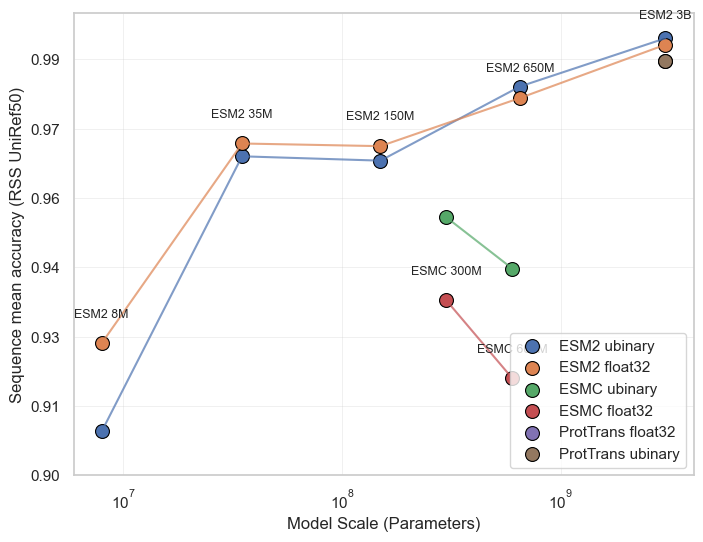

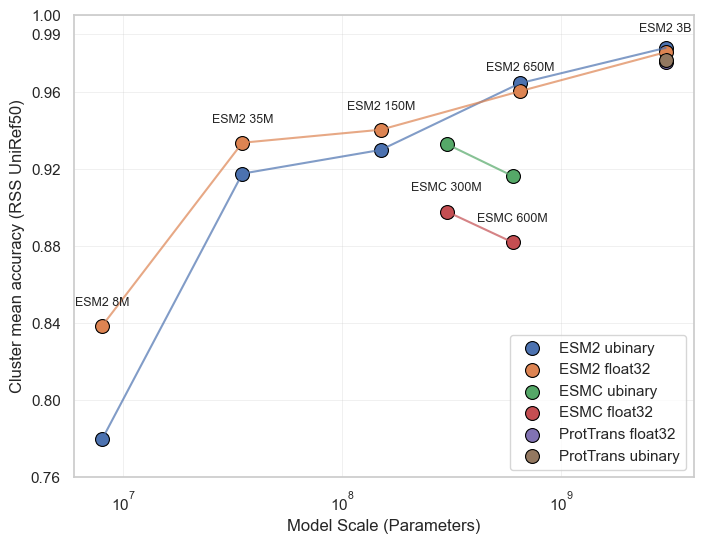

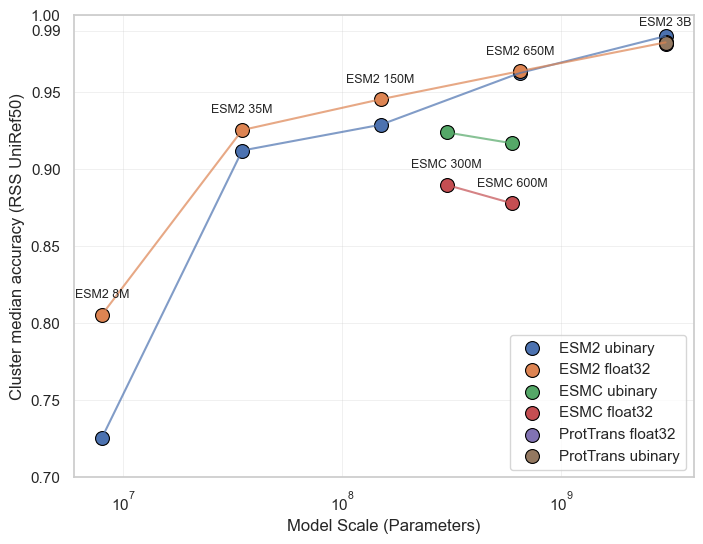

In [9]:
# Load the partition data
partition = 'all'
ylabel_dataname = 'RSS UniRef50'
esm2_float32 = get_metadata(esm2_model_names, 'float32', partition)
esm2_ubinary = get_metadata(esm2_model_names, 'ubinary', partition)
esmc_float32 = get_metadata(esmc_model_names, 'float32', partition)
esmc_ubinary = get_metadata(esmc_model_names, 'ubinary', partition)
prottrans_float32 = get_metadata(prottrans_model_names, 'float32', partition)
prottrans_ubinary = get_metadata(prottrans_model_names, 'ubinary', partition)

metric = 'sequence_level_mean_accuracy'
plot_accuracy_vs_model_size(
    ylabel=f'Sequence mean accuracy ({ylabel_dataname})',
    data={
        'ESM2 ubinary': [
            esm2_plot_sizes,
            get_accuracies(esm2_ubinary, metric),
            [],
        ],
        'ESM2 float32': [
            esm2_plot_sizes,
            get_accuracies(esm2_float32, metric),
            esm2_plot_names,
        ],
        'ESMC ubinary': [
            esmc_plot_sizes,
            get_accuracies(esmc_ubinary, metric),
            [],
        ],
        'ESMC float32': [
            esmc_plot_sizes,
            get_accuracies(esmc_float32, metric),
            esmc_plot_names,
        ],
        'ProtTrans float32': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_float32, metric),
            [],
        ],
        'ProtTrans ubinary': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_ubinary, metric),
            [],
        ],
    },
    annotation_offset=0.005,
    save_path='evaluations/figures/rss_uniref50_sequence_mean_accuracy.pdf',
)

metric = 'cluster_level_mean_accuracy'
plot_accuracy_vs_model_size(
    ylabel=f'Cluster mean accuracy ({ylabel_dataname})',
    data={
        'ESM2 ubinary': [
            esm2_plot_sizes,
            get_accuracies(esm2_ubinary, metric),
            [],
        ],
        'ESM2 float32': [
            esm2_plot_sizes,
            get_accuracies(esm2_float32, metric),
            esm2_plot_names,
        ],
        'ESMC ubinary': [
            esmc_plot_sizes,
            get_accuracies(esmc_ubinary, metric),
            [],
        ],
        'ESMC float32': [
            esmc_plot_sizes,
            get_accuracies(esmc_float32, metric),
            esmc_plot_names,
        ],
        'ProtTrans float32': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_float32, metric),
            [],
        ],
        'ProtTrans ubinary': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_ubinary, metric),
            [],
        ],
    },
    annotation_offset=0.009,
    save_path='evaluations/figures/rss_uniref50_cluster_mean_accuracy.pdf',
)

metric = 'cluster_level_median_accuracy'
plot_accuracy_vs_model_size(
    ylabel=f'Cluster median accuracy ({ylabel_dataname})',
    data={
        'ESM2 ubinary': [
            esm2_plot_sizes,
            get_accuracies(esm2_ubinary, metric),
            [],
        ],
        'ESM2 float32': [
            esm2_plot_sizes,
            get_accuracies(esm2_float32, metric),
            esm2_plot_names,
        ],
        'ESMC ubinary': [
            esmc_plot_sizes,
            get_accuracies(esmc_ubinary, metric),
            [],
        ],
        'ESMC float32': [
            esmc_plot_sizes,
            get_accuracies(esmc_float32, metric),
            esmc_plot_names,
        ],
        'ProtTrans float32': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_float32, metric),
            [],
        ],
        'ProtTrans ubinary': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_ubinary, metric),
            [],
        ],
    },
    annotation_offset=0.009,
    save_path='evaluations/figures/rss_uniref50_cluster_median_accuracy.pdf',
)

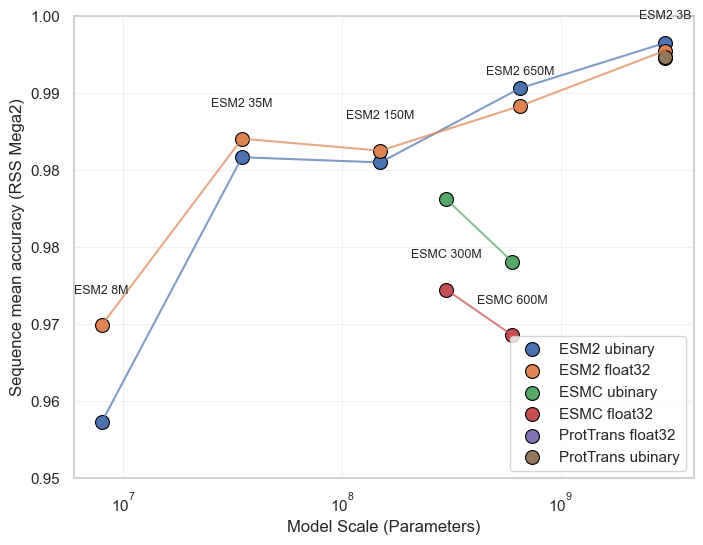

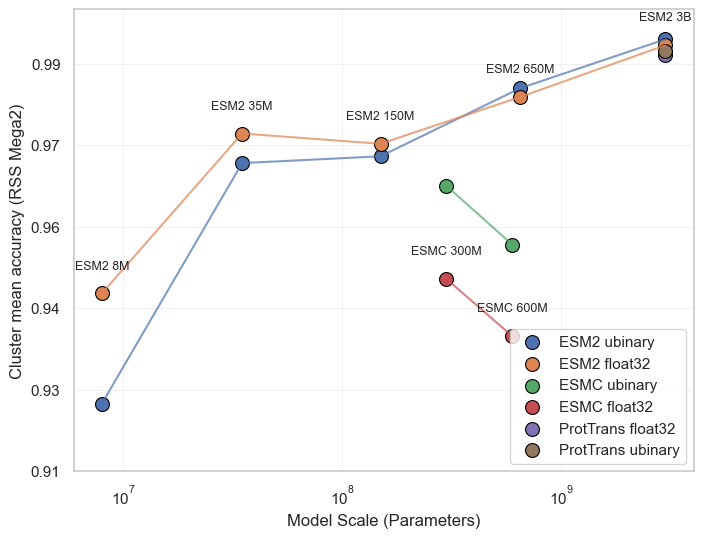

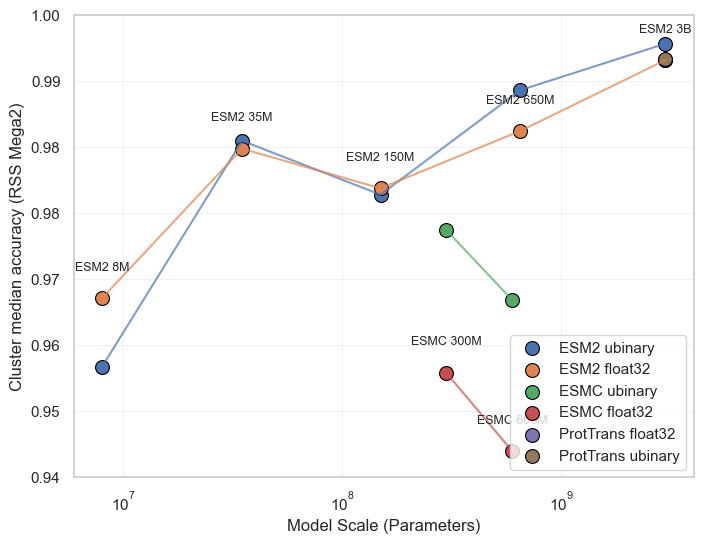

In [10]:
# Load the partition data
partition = 'mega2'
ylabel_dataname = 'RSS Mega2'
esm2_float32 = get_metadata(esm2_model_names, 'float32', partition)
esm2_ubinary = get_metadata(esm2_model_names, 'ubinary', partition)
esmc_float32 = get_metadata(esmc_model_names, 'float32', partition)
esmc_ubinary = get_metadata(esmc_model_names, 'ubinary', partition)
prottrans_float32 = get_metadata(prottrans_model_names, 'float32', partition)
prottrans_ubinary = get_metadata(prottrans_model_names, 'ubinary', partition)

metric = 'sequence_level_mean_accuracy'
plot_accuracy_vs_model_size(
    ylabel=f'Sequence mean accuracy ({ylabel_dataname})',
    data={
        'ESM2 ubinary': [
            esm2_plot_sizes,
            get_accuracies(esm2_ubinary, metric),
            [],
        ],
        'ESM2 float32': [
            esm2_plot_sizes,
            get_accuracies(esm2_float32, metric),
            esm2_plot_names,
        ],
        'ESMC ubinary': [
            esmc_plot_sizes,
            get_accuracies(esmc_ubinary, metric),
            [],
        ],
        'ESMC float32': [
            esmc_plot_sizes,
            get_accuracies(esmc_float32, metric),
            esmc_plot_names,
        ],
        'ProtTrans float32': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_float32, metric),
            [],
        ],
        'ProtTrans ubinary': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_ubinary, metric),
            [],
        ],
    },
    annotation_offset=0.003,
    save_path='evaluations/figures/rss_mega2_sequence_mean_accuracy.pdf',
)

metric = 'cluster_level_mean_accuracy'
plot_accuracy_vs_model_size(
    ylabel=f'Cluster mean accuracy ({ylabel_dataname})',
    data={
        'ESM2 ubinary': [
            esm2_plot_sizes,
            get_accuracies(esm2_ubinary, metric),
            [],
        ],
        'ESM2 float32': [
            esm2_plot_sizes,
            get_accuracies(esm2_float32, metric),
            esm2_plot_names,
        ],
        'ESMC ubinary': [
            esmc_plot_sizes,
            get_accuracies(esmc_ubinary, metric),
            [],
        ],
        'ESMC float32': [
            esmc_plot_sizes,
            get_accuracies(esmc_float32, metric),
            esmc_plot_names,
        ],
        'ProtTrans float32': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_float32, metric),
            [],
        ],
        'ProtTrans ubinary': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_ubinary, metric),
            [],
        ],
    },
    annotation_offset=0.004,
    save_path='evaluations/figures/rss_mega2_cluster_mean_accuracy.pdf',
)

metric = 'cluster_level_median_accuracy'
plot_accuracy_vs_model_size(
    ylabel=f'Cluster median accuracy ({ylabel_dataname})',
    data={
        'ESM2 ubinary': [
            esm2_plot_sizes,
            get_accuracies(esm2_ubinary, metric),
            [],
        ],
        'ESM2 float32': [
            esm2_plot_sizes,
            get_accuracies(esm2_float32, metric),
            esm2_plot_names,
        ],
        'ESMC ubinary': [
            esmc_plot_sizes,
            get_accuracies(esmc_ubinary, metric),
            [],
        ],
        'ESMC float32': [
            esmc_plot_sizes,
            get_accuracies(esmc_float32, metric),
            esmc_plot_names,
        ],
        'ProtTrans float32': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_float32, metric),
            [],
        ],
        'ProtTrans ubinary': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_ubinary, metric),
            [],
        ],
    },
    annotation_offset=0.003,
    save_path='evaluations/figures/rss_mega2_cluster_median_accuracy.pdf',
)

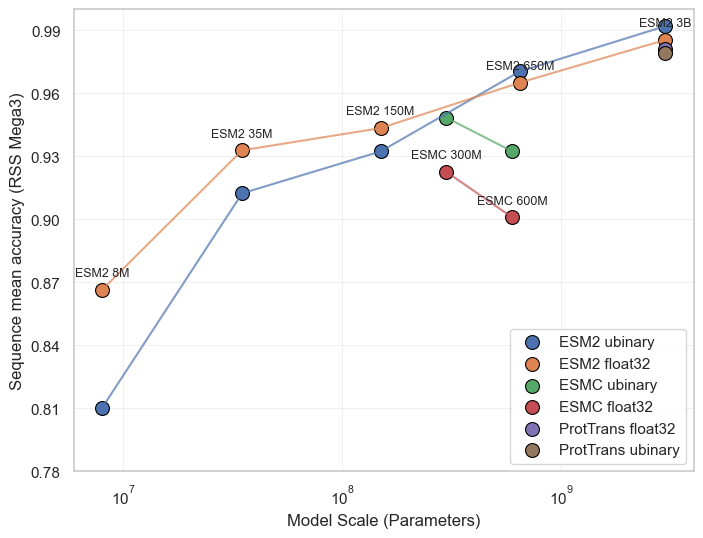

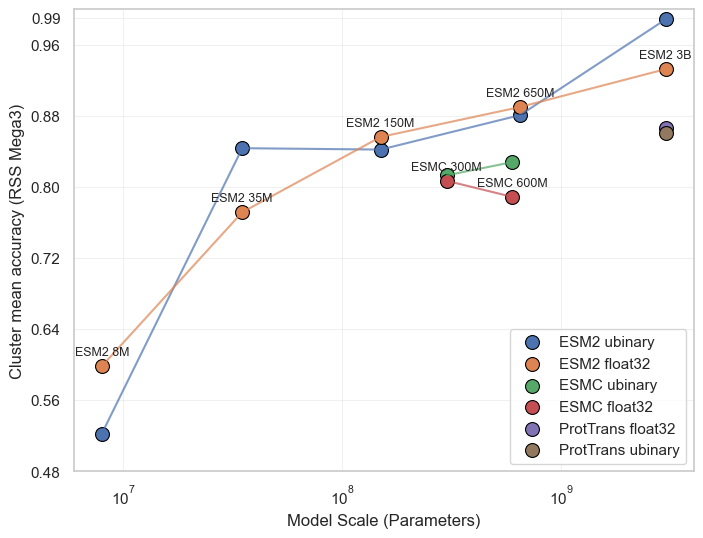

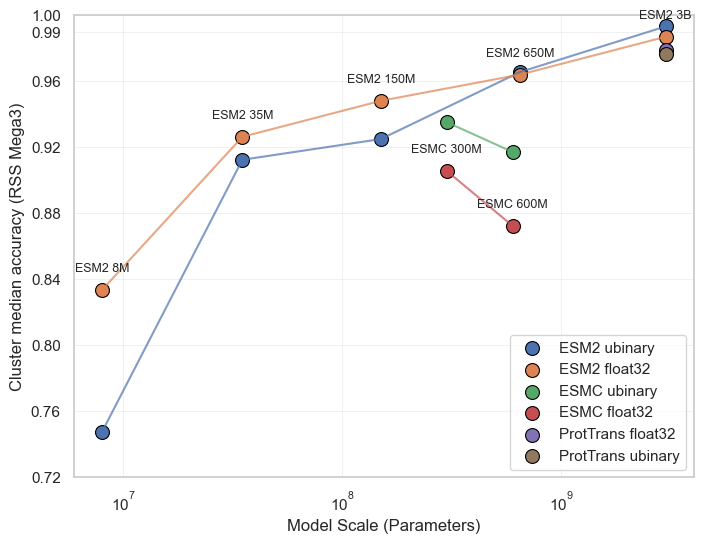

In [11]:
# Load the partition data
partition = 'mega3'
ylabel_dataname = 'RSS Mega3'
esm2_float32 = get_metadata(esm2_model_names, 'float32', partition)
esm2_ubinary = get_metadata(esm2_model_names, 'ubinary', partition)
esmc_float32 = get_metadata(esmc_model_names, 'float32', partition)
esmc_ubinary = get_metadata(esmc_model_names, 'ubinary', partition)
prottrans_float32 = get_metadata(prottrans_model_names, 'float32', partition)
prottrans_ubinary = get_metadata(prottrans_model_names, 'ubinary', partition)

metric = 'sequence_level_mean_accuracy'
plot_accuracy_vs_model_size(
    ylabel=f'Sequence mean accuracy ({ylabel_dataname})',
    data={
        'ESM2 ubinary': [
            esm2_plot_sizes,
            get_accuracies(esm2_ubinary, metric),
            [],
        ],
        'ESM2 float32': [
            esm2_plot_sizes,
            get_accuracies(esm2_float32, metric),
            esm2_plot_names,
        ],
        'ESMC ubinary': [
            esmc_plot_sizes,
            get_accuracies(esmc_ubinary, metric),
            [],
        ],
        'ESMC float32': [
            esmc_plot_sizes,
            get_accuracies(esmc_float32, metric),
            esmc_plot_names,
        ],
        'ProtTrans float32': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_float32, metric),
            [],
        ],
        'ProtTrans ubinary': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_ubinary, metric),
            [],
        ],
    },
    annotation_offset=0.005,
    save_path='evaluations/figures/rss_mega3_sequence_mean_accuracy.pdf',
)

metric = 'cluster_level_mean_accuracy'
plot_accuracy_vs_model_size(
    ylabel=f'Cluster mean accuracy ({ylabel_dataname})',
    data={
        'ESM2 ubinary': [
            esm2_plot_sizes,
            get_accuracies(esm2_ubinary, metric),
            [],
        ],
        'ESM2 float32': [
            esm2_plot_sizes,
            get_accuracies(esm2_float32, metric),
            esm2_plot_names,
        ],
        'ESMC ubinary': [
            esmc_plot_sizes,
            get_accuracies(esmc_ubinary, metric),
            [],
        ],
        'ESMC float32': [
            esmc_plot_sizes,
            get_accuracies(esmc_float32, metric),
            esmc_plot_names,
        ],
        'ProtTrans float32': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_float32, metric),
            [],
        ],
        'ProtTrans ubinary': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_ubinary, metric),
            [],
        ],
    },
    annotation_offset=0.009,
    save_path='evaluations/figures/rss_mega3_cluster_mean_accuracy.pdf',
)

metric = 'cluster_level_median_accuracy'
plot_accuracy_vs_model_size(
    ylabel=f'Cluster median accuracy ({ylabel_dataname})',
    data={
        'ESM2 ubinary': [
            esm2_plot_sizes,
            get_accuracies(esm2_ubinary, metric),
            [],
        ],
        'ESM2 float32': [
            esm2_plot_sizes,
            get_accuracies(esm2_float32, metric),
            esm2_plot_names,
        ],
        'ESMC ubinary': [
            esmc_plot_sizes,
            get_accuracies(esmc_ubinary, metric),
            [],
        ],
        'ESMC float32': [
            esmc_plot_sizes,
            get_accuracies(esmc_float32, metric),
            esmc_plot_names,
        ],
        'ProtTrans float32': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_float32, metric),
            [],
        ],
        'ProtTrans ubinary': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_ubinary, metric),
            [],
        ],
    },
    annotation_offset=0.009,
    save_path='evaluations/figures/rss_mega3_cluster_median_accuracy.pdf',
)

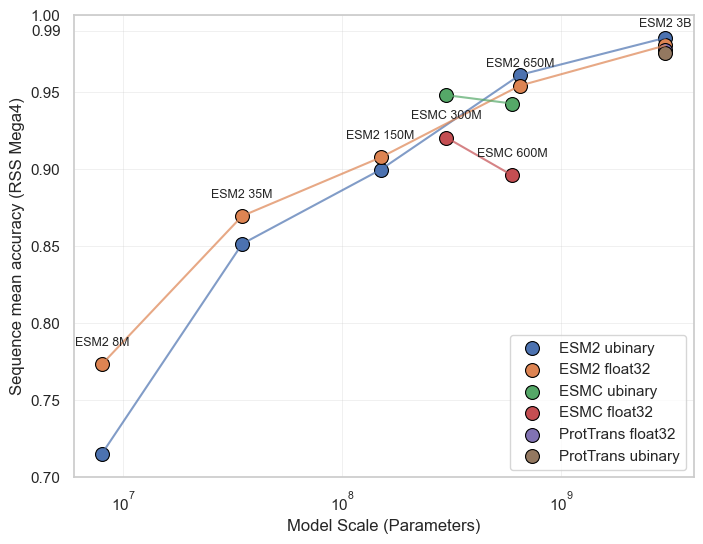

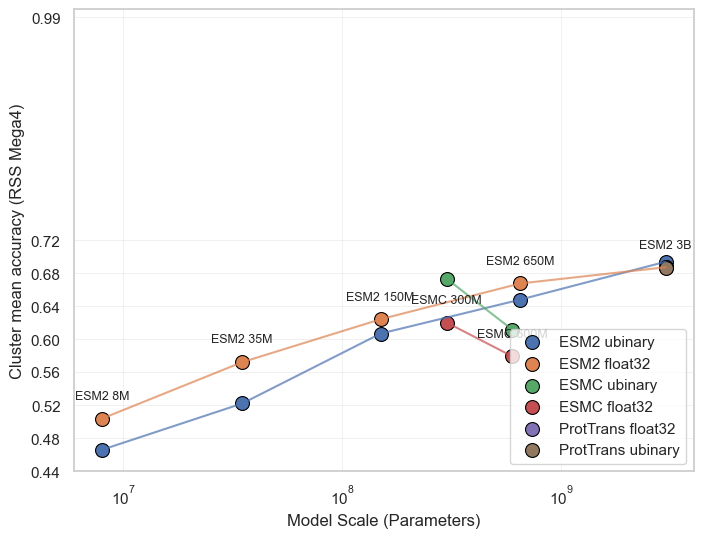

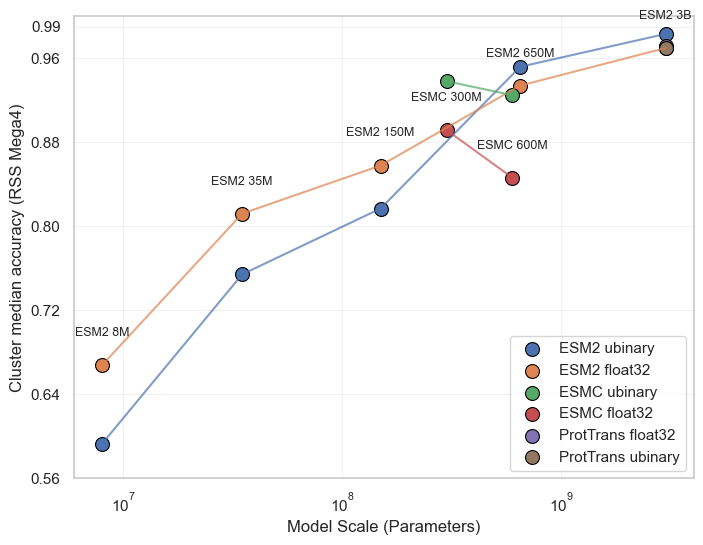

In [12]:
# Load the partition data
partition = 'mega4'
ylabel_dataname = 'RSS Mega4'
esm2_float32 = get_metadata(esm2_model_names, 'float32', partition)
esm2_ubinary = get_metadata(esm2_model_names, 'ubinary', partition)
esmc_float32 = get_metadata(esmc_model_names, 'float32', partition)
esmc_ubinary = get_metadata(esmc_model_names, 'ubinary', partition)
prottrans_float32 = get_metadata(prottrans_model_names, 'float32', partition)
prottrans_ubinary = get_metadata(prottrans_model_names, 'ubinary', partition)

metric = 'sequence_level_mean_accuracy'
plot_accuracy_vs_model_size(
    ylabel=f'Sequence mean accuracy ({ylabel_dataname})',
    data={
        'ESM2 ubinary': [
            esm2_plot_sizes,
            get_accuracies(esm2_ubinary, metric),
            [],
        ],
        'ESM2 float32': [
            esm2_plot_sizes,
            get_accuracies(esm2_float32, metric),
            esm2_plot_names,
        ],
        'ESMC ubinary': [
            esmc_plot_sizes,
            get_accuracies(esmc_ubinary, metric),
            [],
        ],
        'ESMC float32': [
            esmc_plot_sizes,
            get_accuracies(esmc_float32, metric),
            esmc_plot_names,
        ],
        'ProtTrans float32': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_float32, metric),
            [],
        ],
        'ProtTrans ubinary': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_ubinary, metric),
            [],
        ],
    },
    annotation_offset=0.01,
    save_path='evaluations/figures/rss_mega4_sequence_mean_accuracy.pdf',
)

metric = 'cluster_level_mean_accuracy'
plot_accuracy_vs_model_size(
    ylabel=f'Cluster mean accuracy ({ylabel_dataname})',
    data={
        'ESM2 ubinary': [
            esm2_plot_sizes,
            get_accuracies(esm2_ubinary, metric),
            [],
        ],
        'ESM2 float32': [
            esm2_plot_sizes,
            get_accuracies(esm2_float32, metric),
            esm2_plot_names,
        ],
        'ESMC ubinary': [
            esmc_plot_sizes,
            get_accuracies(esmc_ubinary, metric),
            [],
        ],
        'ESMC float32': [
            esmc_plot_sizes,
            get_accuracies(esmc_float32, metric),
            esmc_plot_names,
        ],
        'ProtTrans float32': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_float32, metric),
            [],
        ],
        'ProtTrans ubinary': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_ubinary, metric),
            [],
        ],
    },
    annotation_offset=0.02,
    save_path='evaluations/figures/rss_mega4_cluster_mean_accuracy.pdf',
)

metric = 'cluster_level_median_accuracy'
plot_accuracy_vs_model_size(
    ylabel=f'Cluster median accuracy ({ylabel_dataname})',
    data={
        'ESM2 ubinary': [
            esm2_plot_sizes,
            get_accuracies(esm2_ubinary, metric),
            [],
        ],
        'ESM2 float32': [
            esm2_plot_sizes,
            get_accuracies(esm2_float32, metric),
            esm2_plot_names,
        ],
        'ESMC ubinary': [
            esmc_plot_sizes,
            get_accuracies(esmc_ubinary, metric),
            [],
        ],
        'ESMC float32': [
            esmc_plot_sizes,
            get_accuracies(esmc_float32, metric),
            esmc_plot_names,
        ],
        'ProtTrans float32': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_float32, metric),
            [],
        ],
        'ProtTrans ubinary': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_ubinary, metric),
            [],
        ],
    },
    annotation_offset=0.025,
    save_path='evaluations/figures/rss_mega4_cluster_median_accuracy.pdf',
)

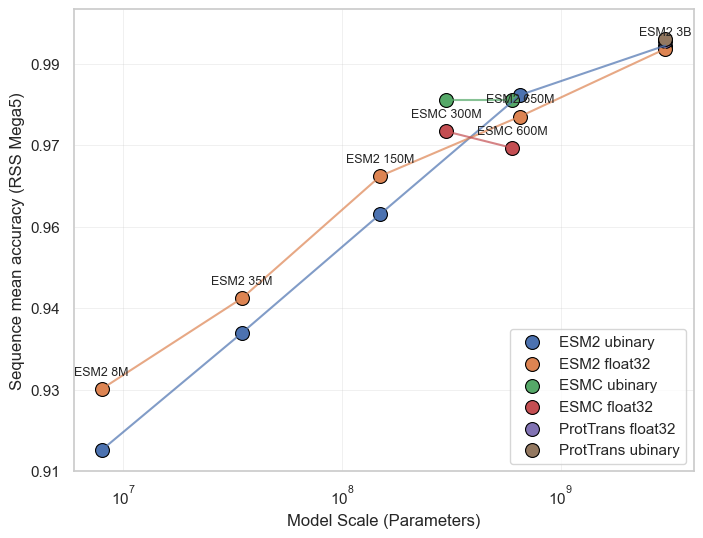

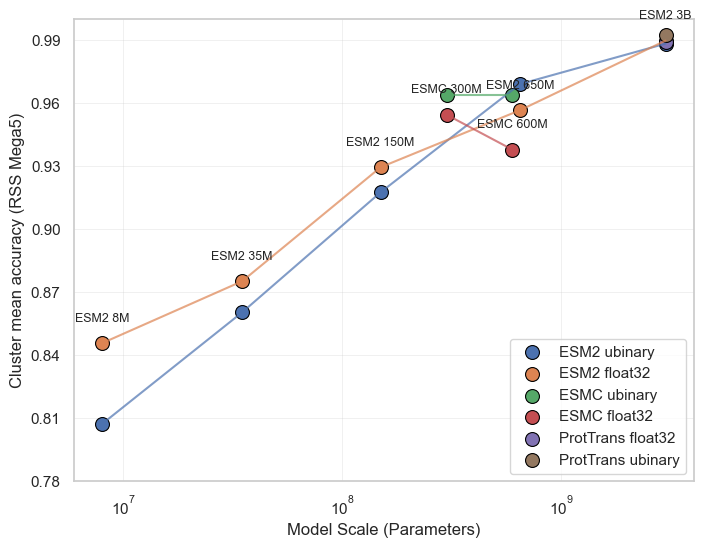

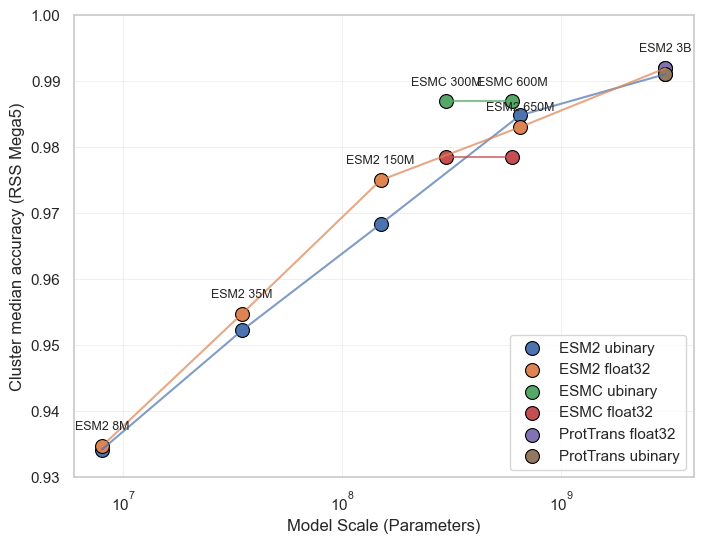

In [13]:
# Load the partition data
partition = 'mega5'
ylabel_dataname = 'RSS Mega5'
esm2_float32 = get_metadata(esm2_model_names, 'float32', partition)
esm2_ubinary = get_metadata(esm2_model_names, 'ubinary', partition)
esmc_float32 = get_metadata(esmc_model_names, 'float32', partition)
esmc_ubinary = get_metadata(esmc_model_names, 'ubinary', partition)
prottrans_float32 = get_metadata(prottrans_model_names, 'float32', partition)
prottrans_ubinary = get_metadata(prottrans_model_names, 'ubinary', partition)

metric = 'sequence_level_mean_accuracy'
plot_accuracy_vs_model_size(
    ylabel=f'Sequence mean accuracy ({ylabel_dataname})',
    data={
        'ESM2 ubinary': [
            esm2_plot_sizes,
            get_accuracies(esm2_ubinary, metric),
            [],
        ],
        'ESM2 float32': [
            esm2_plot_sizes,
            get_accuracies(esm2_float32, metric),
            esm2_plot_names,
        ],
        'ESMC ubinary': [
            esmc_plot_sizes,
            get_accuracies(esmc_ubinary, metric),
            [],
        ],
        'ESMC float32': [
            esmc_plot_sizes,
            get_accuracies(esmc_float32, metric),
            esmc_plot_names,
        ],
        'ProtTrans float32': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_float32, metric),
            [],
        ],
        'ProtTrans ubinary': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_ubinary, metric),
            [],
        ],
    },
    annotation_offset=0.002,
    save_path='evaluations/figures/rss_mega5_sequence_mean_accuracy.pdf',
)

metric = 'cluster_level_mean_accuracy'
plot_accuracy_vs_model_size(
    ylabel=f'Cluster mean accuracy ({ylabel_dataname})',
    data={
        'ESM2 ubinary': [
            esm2_plot_sizes,
            get_accuracies(esm2_ubinary, metric),
            [],
        ],
        'ESM2 float32': [
            esm2_plot_sizes,
            get_accuracies(esm2_float32, metric),
            esm2_plot_names,
        ],
        'ESMC ubinary': [
            esmc_plot_sizes,
            get_accuracies(esmc_ubinary, metric),
            [],
        ],
        'ESMC float32': [
            esmc_plot_sizes,
            get_accuracies(esmc_float32, metric),
            esmc_plot_names,
        ],
        'ProtTrans float32': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_float32, metric),
            [],
        ],
        'ProtTrans ubinary': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_ubinary, metric),
            [],
        ],
    },
    annotation_offset=0.009,
    save_path='evaluations/figures/rss_mega5_cluster_mean_accuracy.pdf',
)

metric = 'cluster_level_median_accuracy'
plot_accuracy_vs_model_size(
    ylabel=f'Cluster median accuracy ({ylabel_dataname})',
    data={
        'ESM2 ubinary': [
            esm2_plot_sizes,
            get_accuracies(esm2_ubinary, metric),
            [],
        ],
        'ESM2 float32': [
            esm2_plot_sizes,
            get_accuracies(esm2_float32, metric),
            esm2_plot_names,
        ],
        'ESMC ubinary': [
            esmc_plot_sizes,
            get_accuracies(esmc_ubinary, metric),
            esmc_plot_names,
        ],
        'ESMC float32': [
            esmc_plot_sizes,
            get_accuracies(esmc_float32, metric),
            [],
        ],
        'ProtTrans float32': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_float32, metric),
            [],
        ],
        'ProtTrans ubinary': [
            prottrans_plot_sizes,
            get_accuracies(prottrans_ubinary, metric),
            [],
        ],
    },
    annotation_offset=0.002,
    save_path='evaluations/figures/rss_mega5_cluster_median_accuracy.pdf',
)